<a href="https://colab.research.google.com/github/Manojkl/PointNet/blob/main/Pointnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os 

os.chdir('/content/gdrive/MyDrive/Pointnet/')

In [ ]:
import numpy as np
import random
import math
from torchvision import transforms, utils
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader

In [ ]:
!pip install path.py;

In [ ]:
from path import Path

In [ ]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
!unzip -q ModelNet10.zip

--2021-02-18 18:15:27--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.61
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.61|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  73.0MB/s    in 6.3s    

2021-02-18 18:15:33 (72.1 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [ ]:
path = Path("ModelNet10")

In [ ]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    # Note: readline reads one line at a time and next time you again call it it remembers the last line stopped reading. Hence onces you finish reading the vertices the next line in faces contains the deatils about the faces the vertices connected to.
    # Second line of the file contains details abou the number of vertices and number of faces in a file
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    # Ignore the first integer using [1:]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    # print(faces)
    return verts, faces
    
with open(path/"bed/train/bed_0001.off", 'r') as f:
    mesh = read_off(f)

In [ ]:
with open(path/"bed/train/bed_0001.off", 'r') as f:
    file = f
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    for s in  for i_face in range(n_faces)]
      print(s)

SyntaxError: ignored

In [ ]:
# Read the number of vertices and faces
verts, faces = mesh
# Intialize a numpy array for every faces
areas = np.zeros((len(faces)))
# Vertices is connverted into numpy array 
verts = np.array(verts)
print(len(areas))
print(verts)

# function to calculate triangle area by its vertices
# https://en.wikipedia.org/wiki/Heron%27s_formula

def triangle_area(pt1, pt2, pt3):
    side_a = np.linalg.norm(pt1 - pt2)
    side_b = np.linalg.norm(pt2 - pt3)
    side_c = np.linalg.norm(pt3 - pt1)
    s = 0.5 * ( side_a + side_b + side_c)
    return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

# we calculate areas of all faces in our mesh
# faces = 4 5 6
# Vertices give us the location of a point in 3D space and three point joining forms a mesh or area. 
for i in range(len(areas)):
    areas[i] = (triangle_area(verts[faces[i][0]],
                              verts[faces[i][1]],
                              verts[faces[i][2]]))
    

1807
[[ 30.       -35.027505 -12.25    ]
 [ 30.       -41.027505 -12.25    ]
 [ 19.75      39.972495   0.75    ]
 ...
 [ -2.143     34.260195   0.75    ]
 [-26.143     17.260195   0.75    ]
 [-26.143     34.260195   0.75    ]]


In [ ]:

k = 3000
# we sample 'k' faces with probabilities proportional to their areas
# weights are used to create a distribution.
# they don't have to sum up to one.
# mylist = ["apple", "banana", "cherry"]
# print(random.choices(mylist, weights = [10, 1, 1], k = 14))
# Return a list with 14 items.
# The list should contain a randomly selection of the values from a specified list, and there should be 10 times higher possibility to select "apple" than the other two:

sampled_faces = (random.choices(faces, 
                                weights=areas,
                                k=k))

# function to sample points on a triangle surface
def sample_point(pt1, pt2, pt3):
    # barycentric coordinates on a triangle
    # https://mathworld.wolfram.com/BarycentricCoordinates.html
    # https://www.scratchapixel.com/lessons/3d-basic-rendering/ray-tracing-rendering-a-triangle/barycentric-coordinates#:~:text=Barycentric%20coordinates%20are%20also%20known,A%2C%20B%2C%20C).
    # random.random() generates random value between 0 and 1.
    s, t = sorted([random.random(), random.random()])
    f = lambda i: s * pt1[i] + (t-s) * pt2[i] + (1-t) * pt3[i]
    return (f(0), f(1), f(2))
 
pointcloud = np.zeros((k, 3))

# sample points on chosen faces for the point cloud of size 'k'
for i in range(len(sampled_faces)):
    pointcloud[i] = (sample_point(verts[sampled_faces[i][0]],
                                  verts[sampled_faces[i][1]],
                                  verts[sampled_faces[i][2]]))

In [ ]:

# normalize
norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

# rotation around z-axis
theta = random.random() * 2. * math.pi # rotation angle
rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                       [ math.sin(theta),  math.cos(theta),    0],
                       [0,                             0,      1]])

rot_pointcloud = rot_matrix.dot(pointcloud.T).T

# add some noise
noise = np.random.normal(0, 0.02, (pointcloud.shape))
noisy_pointcloud = rot_pointcloud + noise

In [ ]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points

In [ ]:

class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [ ]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [ ]:
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)

In [ ]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [ ]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

In [ ]:
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 
                'category': self.classes[category]}

In [ ]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [ ]:
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [ ]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};

In [ ]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([1024, 3])
Class:  bathtub


In [ ]:
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

In [ ]:
import torch

# The torch.nn import gives us access to some helpful neural network things, 
# such as various neural network layer types (things like regular fully-connected layers, convolutional layers (for imagery), recurrent layers...etc)
import torch.nn as nn 

# The torch.nn.functional area specifically gives us access to some handy functions that we might not want to write ourselves. 
# We will be using the relu or "rectified linear" activation function for our neurons. Instead of writing all of the code for these things, we can just import them
import torch.nn.functional as F

# In PyTorch, we use torch.nn to build layers. For example, in __iniit__, we configure different trainable layers including convolution and affine layers with nn.Conv2d and nn.Linear respectively.
# We create the method forward to compute the network output. It contains functionals linking layers already configured in __iniit__ to form a computation graph. Functionals include ReLU and max poolings.

# nn.Conv1d(in_channels=n_hidden, out_channels=n_output, kernel_size=1)
# 1 input image channel, 6 output channels, 5x5 square convolution kernel
# self.conv1 = nn.Conv2d(1, 6, 5)



# CLASS torch.nn.Linear(in_features, out_features, bias=True)
# Applies a linear transformation to the incoming data: y = x*W^T + b
# Parameters:
# in_features – size of each input sample (i.e. size of x)
# out_features – size of each output sample (i.e. size of y)

# Batch norm is about making mean and variance of a batch of example to be 0 and 1 respectively.
# Batch normalization is a technique for training very deep neural networks that normalizes the contributions to a layer for every mini-batch.
# This has the impact of settling the learning process and drastically decreasing the number of training epochs required to train deep neural networks
# torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

# torch.eye(n, m=None, *, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) 
# Returns a 2-D tensor with ones on the diagonal and zeros elsewhere.


class Tnet(nn.Module):

    def __init__(self, k=3):
      # The super() function is used to give access to methods and properties of a parent or sibling class.
      super().__init__()
      self.k = k
      self.conv1 = nn.Conv1d(k, 64, 1)
      self.conv2 = nn.Conv1d(64, 128, 1)
      self.conv3 = nn.Conv1d(128, 1024, 1)
      self.fc1 = nn.Linear(1024, 512)
      self.fc2 = nn.Linear(512, 256)
      self.fc3 = nn.Linear(256, k*k)

      self.bn1 =  nn.BatchNorm1d(64)
      self.bn2 =  nn.BatchNorm1d(128)
      self.bn3 =  nn.BatchNorm1d(1024)
      self.bn4 =  nn.BatchNorm1d(512)
      self.bn5 =  nn.BatchNorm1d(256)

    def forward(self, input):

      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))

      #Initializing an identity

      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)

      if xb.is_cuda:
        init=init.cuda()
      # add identity to the output
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix

In [ ]:
class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)
        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

In [ ]:

class PointNet(nn.Module):
    def __init__(self, classes=10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [ ]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs = outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs, 1, 1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs, 1, 1)
    if outputs.is_cuda:
        id3x3 = id3x3.cuda()
        id64x64 = id64x64.cuda()
    diff3x3 = id3x3 - torch.bmm(m3x3, m3x3.transpose(1, 2))
    diff64x64 = id64x64 - torch.bmm(m64x64, m64x64.transpose(1, 2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3) + torch.norm(diff64x64)) / float(bs)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load("/content/gdrive/My Drive/Pointnet/save_14.pth"))
pointnet.to(device);

In [ ]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [ ]:
def train(model, train_loader, val_loader=None,  epochs=30, save=True):
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        model_save_name = "save_"+str(epoch)+".pth"
        path = F"/content/gdrive/My Drive/Pointnet/"+str(model_save_name)
        # save the model
        if save:
            torch.save(pointnet.state_dict(), path)

In [ ]:
train(pointnet, train_loader, valid_loader,  save=True)

[Epoch: 1, Batch:   10 /  125], loss: 0.413
[Epoch: 1, Batch:   20 /  125], loss: 0.549
[Epoch: 1, Batch:   30 /  125], loss: 0.347
[Epoch: 1, Batch:   40 /  125], loss: 0.442
[Epoch: 1, Batch:   50 /  125], loss: 0.300
[Epoch: 1, Batch:   60 /  125], loss: 0.350
[Epoch: 1, Batch:   70 /  125], loss: 0.404
[Epoch: 1, Batch:   80 /  125], loss: 0.354
[Epoch: 1, Batch:   90 /  125], loss: 0.321
[Epoch: 1, Batch:  100 /  125], loss: 0.345
[Epoch: 1, Batch:  110 /  125], loss: 0.338
[Epoch: 1, Batch:  120 /  125], loss: 0.289
Valid accuracy: 83 %
[Epoch: 2, Batch:   10 /  125], loss: 0.297
[Epoch: 2, Batch:   20 /  125], loss: 0.286
[Epoch: 2, Batch:   30 /  125], loss: 0.378
[Epoch: 2, Batch:   40 /  125], loss: 0.386
[Epoch: 2, Batch:   50 /  125], loss: 0.358
[Epoch: 2, Batch:   60 /  125], loss: 0.381
[Epoch: 2, Batch:   70 /  125], loss: 0.404
[Epoch: 2, Batch:   80 /  125], loss: 0.338
[Epoch: 2, Batch:   90 /  125], loss: 0.284
[Epoch: 2, Batch:  100 /  125], loss: 0.248
[Epoch: 2, 

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load('save_14.pth'))
pointnet.eval();

In [ ]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]
Batch [  15 /   15]


In [ ]:
cm = confusion_matrix(all_labels, all_preds);

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};

Normalized confusion matrix


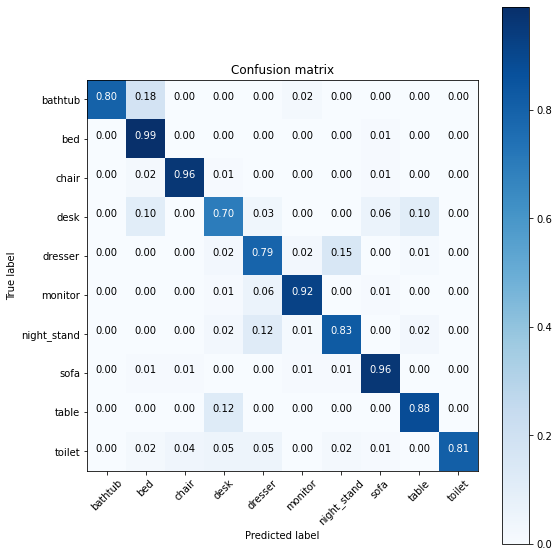

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Confusion matrix, without normalization


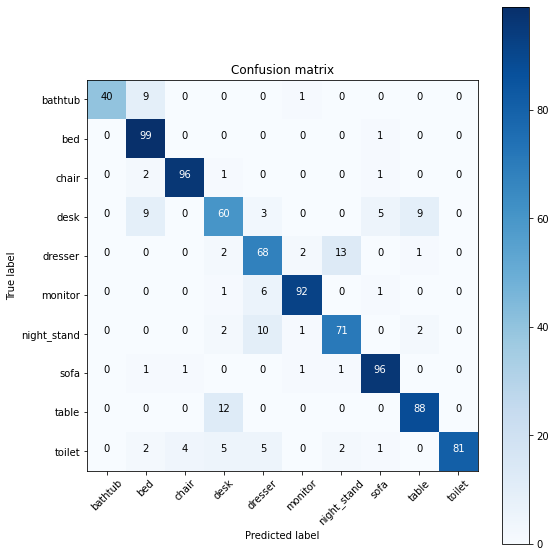

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)